In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import numpy as np

In [ ]:
# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

LOGS_PATH = './llm_server/logs/llm_metrics.csv'
REPORTS_PATH = './ghidra_bench/outputs/reports/*.json'

In [29]:
def load_metrics(path):
    try:
        df = pd.read_csv(path)     
        df = df.drop(columns=df.columns[:2])
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return pd.DataFrame()

    return df

df_metrics = load_metrics(LOGS_PATH)

print(f"Loaded {len(df_metrics)} hardware metric records.")
df_metrics.head()

Loaded 1190 hardware metric records.


,model_id,operation,duration_sec,peak_vram_gb,system_ram_gb
0,qwen-coder,score,18.8693,7.7253,2.2641
1,qwen-coder,score,0.8107,7.7253,2.2641
2,qwen-coder,generate,7.0858,8.6530,2.3921
3,qwen-coder,score,0.8009,7.6192,2.3924
4,qwen-coder,score,3.5517,7.6390,2.3924


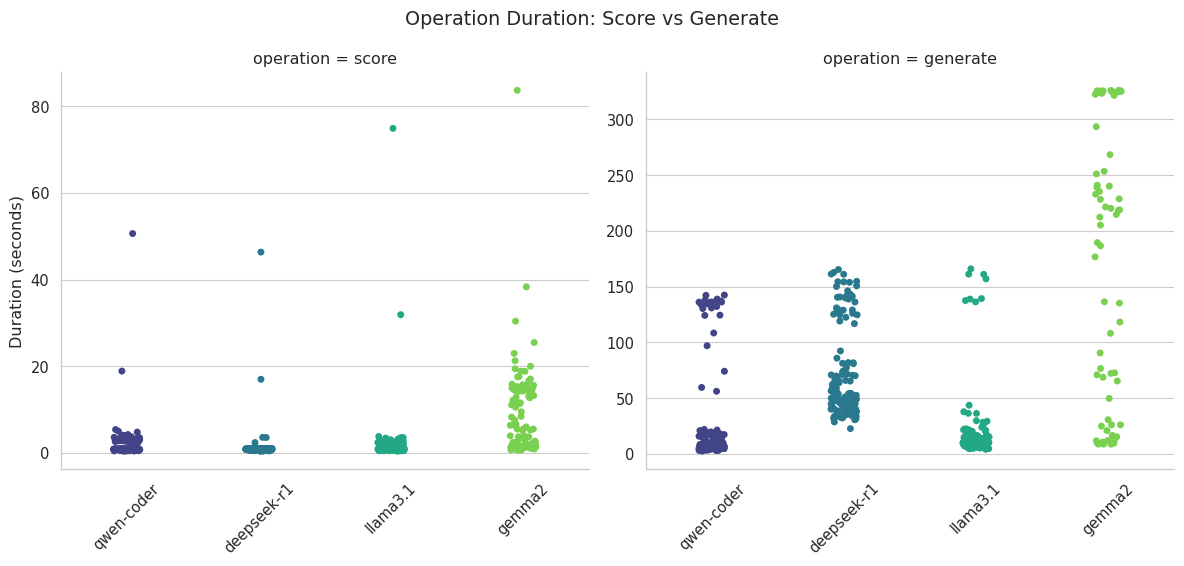

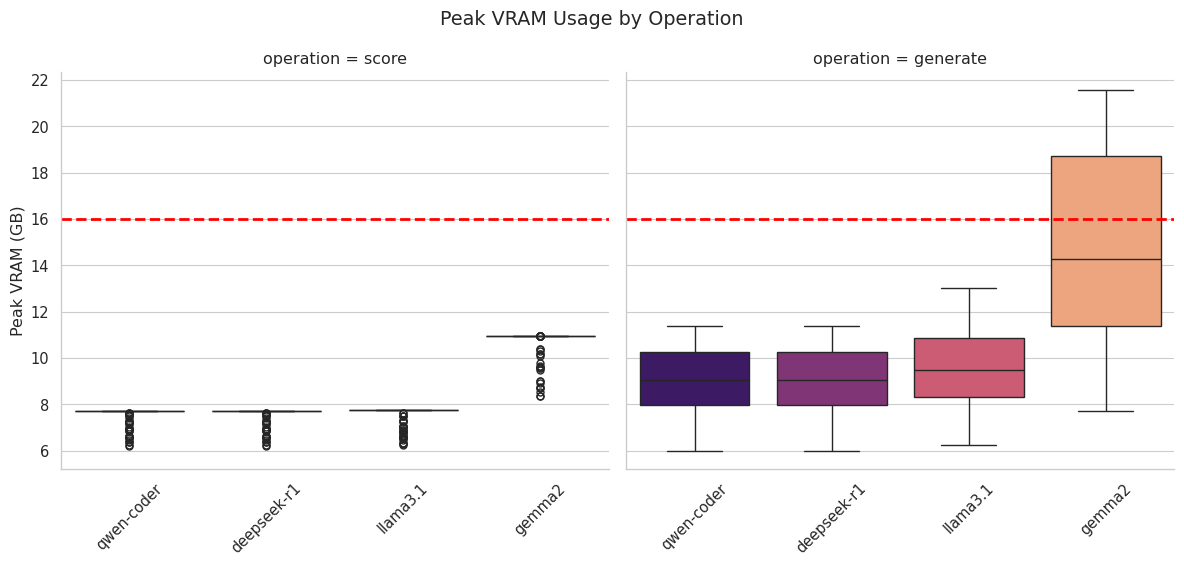

In [67]:
if not df_metrics.empty:
    g = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='duration_sec', 
        col='operation',  # split for 'score' and 'generate'
        kind='strip',
        hue='model_id', 
        palette='viridis', 
        height=5, 
        aspect=1.2,
        sharey=False      # Independent Y-axis
    )
    g.figure.suptitle('Operation Duration: Score vs Generate', y=1.05)
    g.set_axis_labels("", "Duration (seconds)")
    g.set_xticklabels(rotation=45)
    
    g_vram = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='peak_vram_gb',
        col='operation',
        kind='box', 
        hue='model_id', 
        palette='magma', 
        height=5, 
        aspect=1.2
    )
    g_vram.figure.suptitle('Peak VRAM Usage by Operation', y=1.05)
    g_vram.set_axis_labels("", "Peak VRAM (GB)")
    g_vram.set_xticklabels(rotation=45)
    for ax in g_vram.axes.flat:
        ax.axhline(16, color='red', linestyle='--', linewidth=2, label='Limit VRAM')
        

    plt.show()
else:
    print("No metrics data found.")

In [32]:
def load_reports(path_pattern):
    report_files = glob.glob(path_pattern)
    
    clean_data = []
    model_stats = {}

    def update_stat(model, stat_type):
        if model not in model_stats:
            model_stats[model] = {'unknown_winner': 0, 'llm_error': 0, 'valid': 0}
        model_stats[model][stat_type] += 1

    for file in report_files:
        try:
            with open(file, 'r') as f:
                data = json.load(f)
            
            pr_number = data.get('pr', 'Unknown')
            results_dict = data.get('results', {})
            
            for model_name, function_list in results_dict.items():
                if not isinstance(function_list, list):
                    continue
                    
                for entry in function_list:
                    if not isinstance(entry, dict):
                        continue

                    llm_analysis = entry.get('llm_analysis')
                    if 'error' in llm_analysis:
                        update_stat(model_name, 'llm_error')
                        continue

                    winner = llm_analysis.get('winner')
                    if winner == 'Unknown':
                        update_stat(model_name, 'unknown_winner')
                        continue
                        
                    # Valid
                    metrics = entry.get('metrics', {})
                    row = {
                        'pr': pr_number,
                        'model': model_name,
                        'binary': entry.get('binary', 'N/A'),
                        'function': entry.get('function', 'Unknown'),
                        'base_ppl': metrics.get('base_ppl'),
                        'pr_ppl': metrics.get('pr_ppl'),
                        'delta_ppl': metrics.get('delta_ppl'),
                        'winner': winner
                    }
                    clean_data.append(row)
                    update_stat(model_name, 'valid')
                    
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            
    return pd.DataFrame(clean_data), pd.DataFrame(model_stats).T

df_reports, df_stats = load_reports(REPORTS_PATH)
    
display(df_stats)
df_reports.head()

,unknown_winner,llm_error,valid
qwen-coder,20,0,890
deepseek-r1,39,0,871
llama3.1,7,0,903
gemma2,103,39,768


,pr,model,binary,function,base_ppl,pr_ppl,delta_ppl,winner
0,8490,qwen-coder,4stage,FUN_14000f230,1.565430,1.565430,0.000000,Tie
1,8490,qwen-coder,4stage,FUN_140011a3c,1.437500,1.417969,-0.019531,B
2,8490,qwen-coder,4stage,qsort,1.712891,1.684570,-0.028320,A
3,8490,qwen-coder,4stage,InternalCompareStringA,1.767578,1.826172,0.058594,A
4,8490,qwen-coder,4stage,_wcstombs_l_helper,2.089844,2.160156,0.070312,Tie


=== Coherence Analysis (Base) ===


,Model,Total Cases,Consistent Winners,Consistency Rate
0,deepseek-r1,294,39,0.132653
1,gemma2,408,87,0.213235
2,llama3.1,412,326,0.791262
3,qwen-coder,420,7,0.016667


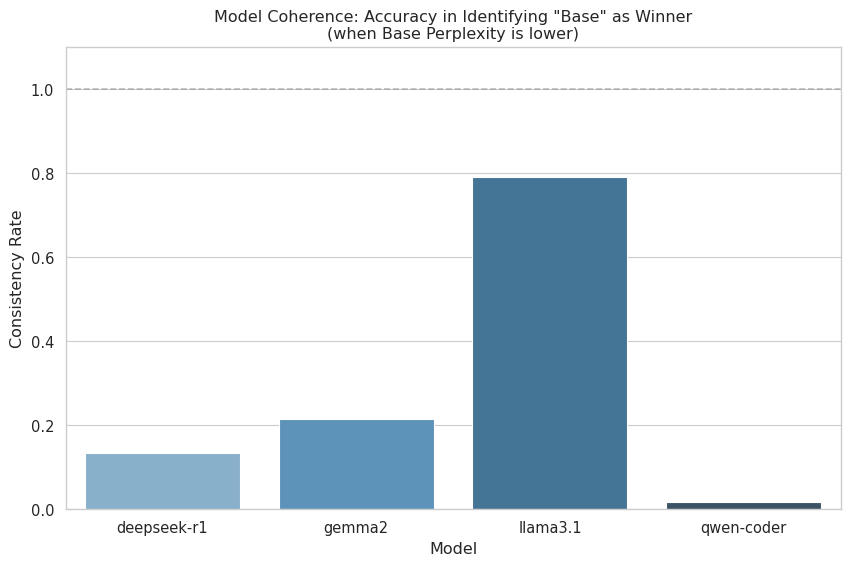

=== Coherence Analysis (PR) ===


,Model,Total Cases,Consistent Winners,Consistency Rate
0,deepseek-r1,547,189,0.345521
1,gemma2,343,31,0.090379
2,llama3.1,450,158,0.351111
3,qwen-coder,434,52,0.119816


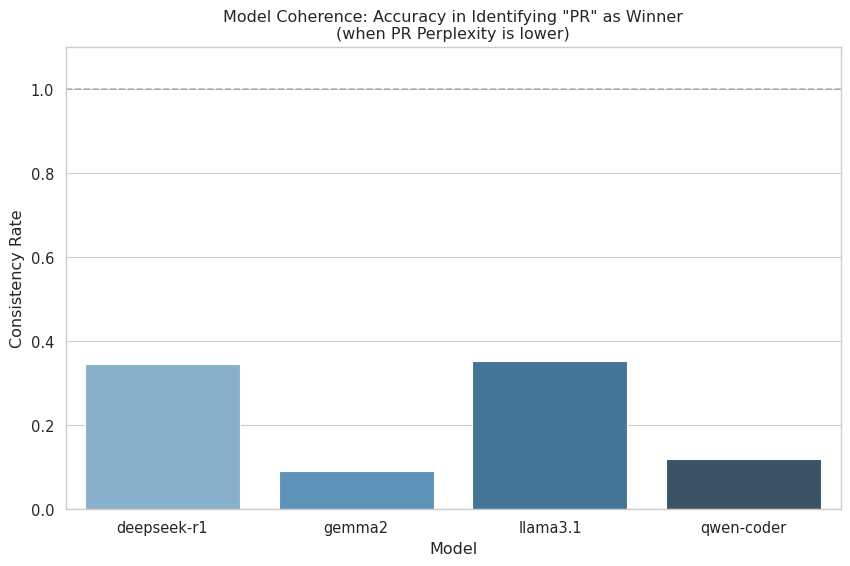

In [36]:
def analyze_coherence(df_reports, title, winner_labels, is_lower):
    if not df_reports.empty:
        
        # Base is better when is_lower is True
        base_better_mask = df_reports['delta_ppl'] > 0 if is_lower else df_reports['delta_ppl'] < 0
        df_consistency = df_reports[base_better_mask].copy()

        valid_base_winners = winner_labels
        
        df_consistency['is_consistent'] = df_consistency['winner'].apply(
            lambda x: any(k in str(x) for k in valid_base_winners)
        )
        
        # Calculate Consistency Rate per Model
        coherence_stats = df_consistency.groupby('model')['is_consistent'].agg(['count', 'sum', 'mean']).reset_index()
        coherence_stats.columns = ['Model', 'Total Cases', 'Consistent Winners', 'Consistency Rate']
        
        print(f"=== Coherence Analysis ({'Base' if is_lower else 'PR'}) ===")
        display(coherence_stats)
        
        # Plotting Consistency
        plt.figure(figsize=(10, 6))
        sns.barplot(data=coherence_stats, x='Model', hue='Model', y='Consistency Rate', palette='Blues_d', legend=False)
        plt.title(f'Model Coherence: Accuracy in Identifying {title}')
        plt.ylim(0, 1.1)
        plt.ylabel('Consistency Rate')
        plt.axhline(1.0, linestyle='--', color='grey', alpha=0.5)
        plt.show()


obj = [{
    "title":'"Base" as Winner\n(when Base Perplexity is lower)',
    "winner": ['A', 'Base'],
    "islower": True
},
{
    "title":'"PR" as Winner\n(when PR Perplexity is lower)',
    "winner": ['B', 'PR'],
    "islower": False
}
]
for item in obj:
    analyze_coherence(df_reports, item['title'], item['winner'], item['islower'])

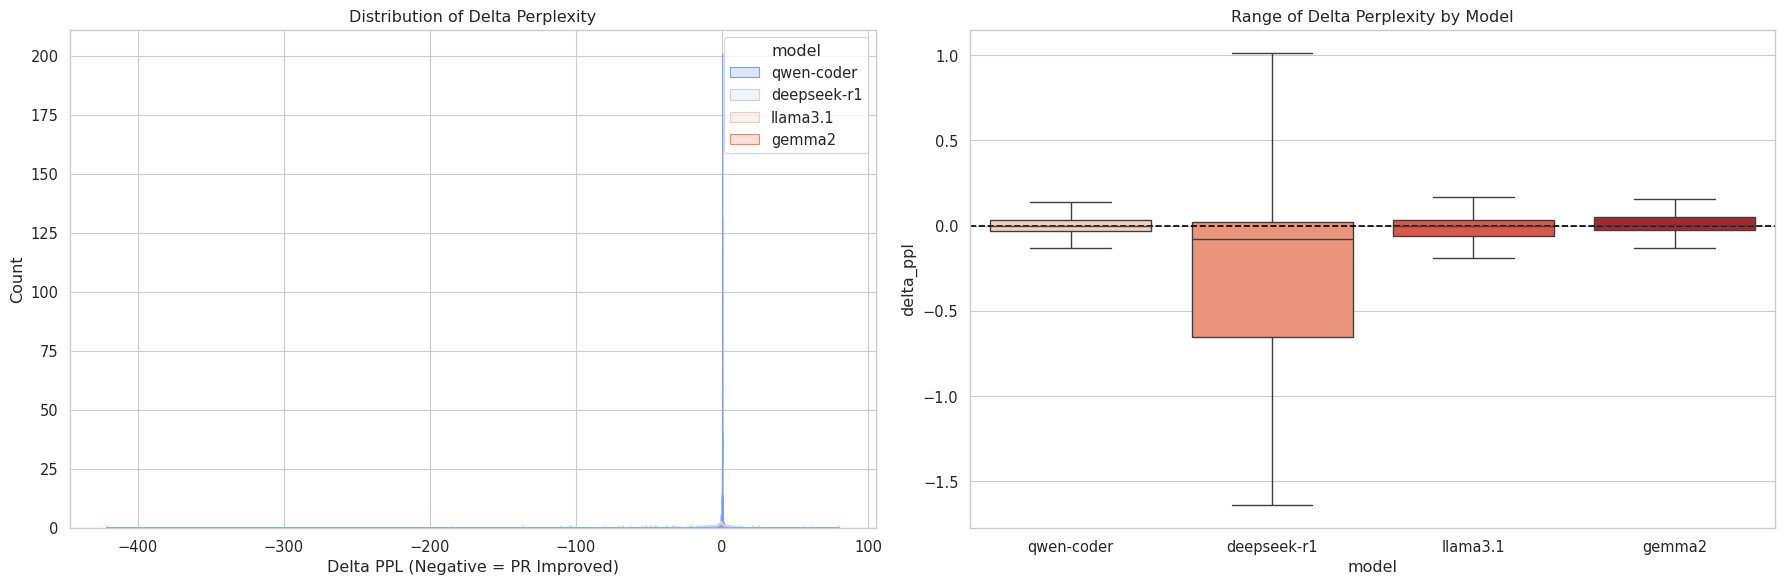

In [59]:
if not df_reports.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    sns.histplot(
        data=df_reports, 
        x='delta_ppl', 
        hue='model', 
        kde=True, 
        element="step", 
        ax=axes[0],
        palette='coolwarm'
    )
    axes[0].set_title('Distribution of Delta Perplexity')
    axes[0].set_xlabel('Delta PPL (Negative = PR Improved)')

    sns.boxplot(
        data=df_reports, 
        x='model', 
        y='delta_ppl', 
        hue='model',
        ax=axes[1], 
        palette='Reds',
        showfliers=False,   # Hide outliers for clarity
        dodge=False
    )
    axes[1].set_title('Range of Delta Perplexity by Model')
    axes[1].axhline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()

In [54]:
if not df_reports.empty:
    print(f"=== Top 20 Functions with Highest Perplexity Change for Model: ===")
    unique_models = df_reports['model'].unique()
    for model in unique_models:
        print(f"\n--- Model: {model} ---")
        df_model = df_reports[df_reports['model'] == model]
        df_model.loc[:, 'abs_delta'] = df_model['delta_ppl'].abs()
        
        top_changes = df_model.sort_values('abs_delta', ascending=False).head(20)
        
        cols = ['pr', 'binary', 'function', 'abs_delta', 'delta_ppl', 'winner']
        
        # Styling the table for readability
        styled_table = top_changes[cols].style.background_gradient(
            subset=['abs_delta'], cmap='RdBu_r'
        ).format({'abs_delta': "{:.4f}"})
        
        display(styled_table)

=== Top 20 Functions with Highest Perplexity Change for Model: ===

--- Model: qwen-coder ---


,pr,binary,function,abs_delta,delta_ppl,winner
598,8827,N/A,rl_beg_of_line,4.0000,4.000000,Tie
577,8827,N/A,set_sigchld_handler,2.9531,2.953125,Tie
2113,8834,N/A,sh_notbuiltin,2.1719,2.171875,Tie
650,8827,N/A,FUN_0008f64c,1.8789,-1.878906,B
541,8827,N/A,FUN_140003814,1.6055,1.605469,B
2136,8834,N/A,FUN_00134320,1.4609,-1.460938,Tie
535,8827,N/A,FUN_140003f94,1.3906,1.390625,Tie
842,8827,N/A,FUN_001103d0,1.2539,1.253906,B
617,8827,N/A,FUN_0008da44,1.1895,-1.189453,B
586,8827,N/A,rl_backward_char_search,1.1758,1.175781,Tie



--- Model: deepseek-r1 ---


,pr,binary,function,abs_delta,delta_ppl,winner
2704,8834,N/A,__assert_fail,421.0000,-421.000000,Tie
2427,8834,N/A,FUN_140008d5c,184.8750,-184.875000,Tie
2726,8834,N/A,setenv,136.5000,-136.500000,Tie
2724,8834,N/A,fnmatch,110.5000,-110.500000,Tie
2711,8834,N/A,FUN_00114a00,104.6250,-104.625000,Tie
2695,8834,N/A,fseeko,103.5000,-103.500000,B
2477,8834,N/A,strcmp,80.2500,-80.250000,Tie
887,8827,N/A,FUN_140004b0c,80.0000,80.000000,Tie
2698,8834,N/A,gethostname,70.7500,-70.750000,Tie
2687,8834,N/A,sigaddset,68.1250,-68.125000,Tie



--- Model: llama3.1 ---


,pr,binary,function,abs_delta,delta_ppl,winner
2792,8834,N/A,strvec_mcreate,11.9844,-11.984375,A or B
1300,8827,N/A,unset_sigwinch_handler,10.6875,10.687500,A
1493,8827,N/A,FUN_004c8d5b,8.2500,8.250000,A
3053,8834,N/A,FUN_001168a0,6.0391,-6.039062,B
2829,8834,N/A,fcntl,5.9688,-5.968750,B
2756,8834,N/A,FUN_14002227a,5.7969,-5.796875,B
3060,8834,N/A,readlink,5.0469,-5.046875,A or B or Tie
1279,8827,N/A,quote_rhs,4.7500,4.750000,A
3065,8834,N/A,fnmatch,4.3906,-4.390625,Tie
3054,8834,N/A,FUN_00118390,4.1875,-4.187500,B



--- Model: gemma2 ---


,pr,binary,function,abs_delta,delta_ppl,winner
1562,8827,N/A,FUN_140004b0c,3.0312,3.031250,Tie
3115,8834,N/A,_cexit,2.1406,-2.140625,Tie
1621,8827,N/A,executable_or_directory,1.9922,1.992188,Tie
1623,8827,N/A,rl_capitalize_word,1.8828,1.882812,Tie
3393,8834,N/A,__assert_fail,1.5938,-1.593750,Tie
1652,8827,N/A,assoc_keys_to_word_list,1.5312,1.531250,Tie
1670,8827,N/A,FUN_000bd9bc,1.5137,-1.513672,A
1632,8827,N/A,strvec_create,1.4844,1.484375,Tie
1622,8827,N/A,rl_possible_completions,1.3516,1.351562,Tie
1854,8827,N/A,FUN_001103c0,1.3203,1.320312,Tie
